In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import ncx2, sampling, gaussian_kde
from scipy.optimize import minimize
import os
import pickle
import time
from calcwf import *
from interpolating_match import *
from simple_pe_funcs import *

We want to generate an example waveform with no noise, single detector, loud (SNR~40), chirp=24, and be able to match filter and resolve the eccentricity away from zero.

# Match filtering to get SNR

We can use functions from simple pe to obtain the match filtered SNR in each 'mode' (i.e. h0, h1, etc.). As we are currently unable to install simple-pe in the same environment as the eccentric branch of teobresums, I have simply copied the necessary functions to simple_pe_funcs.py with only minor edits where necessary such that other simple pe functions are called correctly.

In [2]:
# Set up parameters
s_teob = gen_wf(10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS', distance=854)
_, h0, h1, h2, h3, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)
h0, h1, h2, h3, s_teob = resize_wfs([h0, h1, h2, h3, s_teob])
h0_f, h1_f, h2_f, h3_f, s_teob_f = [wf.real().to_frequencyseries() for wf in [h0, h1, h2, h3, s_teob]]
psd, _ = gen_psd(s_teob, 10)
data = {'H1': s_teob_f, 'L1': s_teob_f}
psds = {'H1': psd, 'L1': psd}
t_start = s_teob.sample_times[0]
t_end = s_teob.sample_times[-1]
h = {'h0': h0_f, 'h1': h1_f, 'h2': h2_f, 'h3': h3_f}

In [3]:
ifos = ['H1']
z = {}
for ifo in ifos:

    # Normalise waveform modes
    h_perp = {}
    for key in h.keys():
        h_perp[key] = h[key] / sigma(h[key], psds[ifo], low_frequency_cutoff=10, high_frequency_cutoff=psds[ifo].sample_frequencies[-1])
    
    # Calculate mode SNRs
    mode_SNRs, _ = calculate_mode_snr(data[ifo], psds[ifo], h_perp, t_start, t_end, 10, h_perp.keys(), dominant_mode='h0')
    z[ifo] = mode_SNRs

# Calculate network SNRs
rss_snr, net_snr = network_mode_snr(z, ifos, z[ifos[0]].keys(), dominant_mode='h0')

# Calculate matched filter network SNR
mfnet_SNR = np.linalg.norm(np.array(list(rss_snr.values())))

# Print results
print(f'Mode SNRs: \n{z}')
print(f'Root sum square SNRs: \n{rss_snr}')
print(f'Network SNRs: \n{net_snr}')
print(f'Matched filter network SNR: {mfnet_SNR}')

Mode SNRs: 
{'H1': {'h0': (39.7181007114985+0.002751398448081068j), 'h1': (4.48480061956443-0.04717423232595036j), 'h2': (1.3462693393842986+0.05299346345814205j), 'h3': (0.7886709925504876-0.13998020496131103j)}}
Root sum square SNRs: 
{'h0': 39.71810080679754, 'h1': 4.485048718290699, 'h2': 1.3473119317127438, 'h3': 0.8009971237598683}
Network SNRs: 
{'h0': 39.71810080679754, 'h1': 4.485048718290699, 'h2': 1.3473119317127438, 'h3': 0.8009971237598682}
Matched filter network SNR: 40.001250474678656


Mode SNRs are the (complex) SNRs of each mode in each detector. \
Root sum square SNRs sum each detector's component in quadrature. \
Network SNRs require that the relative phase between ifos is consistent with the dominant mode (believe equivalent to rss SNR for no noise case). \
Matched filter network SNR is the total SNR across all modes.

# Non-central chi-squared distribution

(observed SNR)**2 can be modelled as a non-central chi-squared distribution with a non-centrality parameter of (expected SNR)**2. We can also flip this round to put in an observed SNR as the non-centrality parameter and see the distibution of expected SNRs that could cause it. We need to model the SNR of the first eccentric correction using this distribution.

Text(0, 0.5, 'P(Expected SNR)')

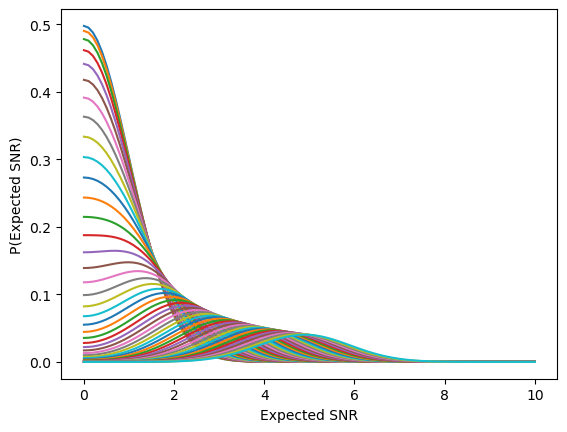

In [4]:
# Plot ncx2 distributions with 2df and various non-centrality parameters
for i in np.linspace(0.1, 5, 50):
    o_SNR = i
    df = 2
    nc = o_SNR**2
    
    e_SNR = np.linspace(0.001, 10, 101)
    p_h1 = ncx2.pdf(e_SNR**2, df, nc)
    plt.plot(e_SNR, p_h1)
plt.xlabel('Expected SNR')
plt.ylabel('P(Expected SNR)')

# Confidence interval

To find the 90% confidence interval we cannot simply take off the outer two 5% parts, instead we should find the shortest possible 90% confidence interval. For SNRs where the distribution rails against zero this is simply the lowest 90% however for louder SNRs we must take a different approach.

We can write a function that returns the length of the confidence interval when x% removed from the left and 10-x% removed from the right. We can then simply use scipy.optimize to find the value of x which minimizes the length.

In [2]:
# Gets 90% confidence bounds (in SNR^2 space) with x% cutoff from left
def dist_CI(rv, x, CI=0.9):
    q = np.array([x, x+CI])
    CI_bounds = rv.ppf(q)
    return CI_bounds

# Gets 90% confidence bounds (in SNR space) with shortest possible distance (in SNR**2 space)
def dist_min_CI(rv, CI=0.9):

    min_result = minimize(lambda x: abs(np.diff(dist_CI(rv, x[0], CI=CI))[0]), 0.05, bounds=[(0,0.1)])
    min_x = min_result['x'][0]

    return np.sqrt(dist_CI(rv, min_x, CI=CI))

[0.        2.6019474]
[0.         3.47338227]
[1.06017093 4.49606331]
[2.18192313 5.53479227]


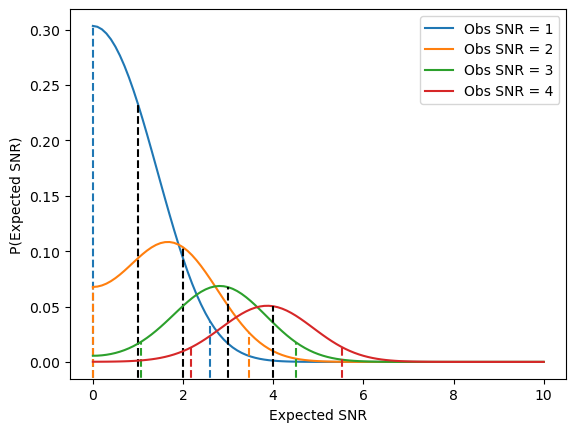

In [6]:
# Plot 90% confidence bounds on their ncx2 distributions
for i in range(4):
    o_SNR = (i+1)
    df = 2
    nc = o_SNR**2
    
    e_SNR = np.linspace(0.001, 10, 101)
    rv = ncx2(df, nc)
    p_h1 = rv.pdf(e_SNR**2)
    plt.plot(e_SNR, p_h1, c=f'C{i}', label=f'Obs SNR = {i+1}')

    CI_bounds = dist_min_CI(rv)
    print(CI_bounds)
    if CI_bounds[0] == 0:
        CI_bounds[0] = 1e-18
    ylim = plt.gca().get_ylim()
    plt.vlines(CI_bounds, -1, rv.pdf(CI_bounds**2), color=f'C{i}', ls='dashed')
    plt.vlines(i+1, -1, rv.pdf((i+1)**2), color='k', ls='dashed')
    plt.ylim(ylim)

plt.xlabel('Expected SNR')
plt.ylabel('P(Expected SNR)')
plt.legend()

This seems to work well! For observed SNRs of 1 and 2, we the CI includes zero, for observed SNRs of 3 and 4, the CI lower bound is greater than zero.

Text(0, 0.5, 'Expected SNR')

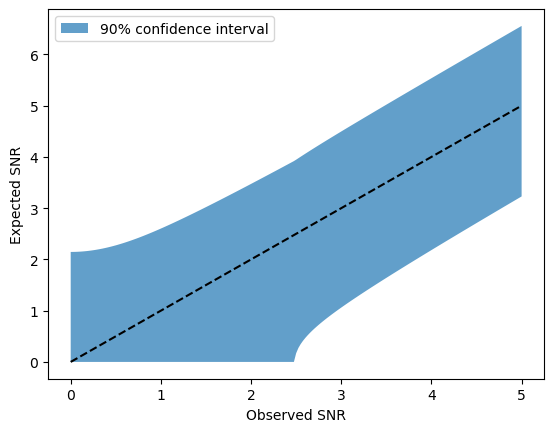

In [7]:
# Calculate 90% confidence bounds for dense array of observed SNRs
CI_bounds = []
obs_arr = np.linspace(0, 5, 201)
for obs in obs_arr:
    rv = ncx2(2, obs**2)
    CI_bounds.append(dist_min_CI(rv))
CI_bounds = np.array(CI_bounds)

# Make plot
plt.fill_between(obs_arr, CI_bounds.T[0], CI_bounds.T[1], alpha=0.7, label='90% confidence interval')
plt.plot(obs_arr, obs_arr, c='k', ls='dashed', zorder=3)
plt.legend(loc='upper left')
plt.xlabel('Observed SNR')
plt.ylabel('Expected SNR')

We can find exact observed SNR at which the CI moves away from zero using scipy.optimize once again to find the SNR at which p(Expected SNR = 0) = p(Expected SNR = ppf(0.9)). In reality p(Expected SNR = 0) is always zero, and so we instead choose an arbitrarily small x of 10^-18. The result does not change to machine precision when decreasing further than this.

In [8]:
# Find minimum resolvable h1 SNR
def min_resolve_SNR(CI=0.9):

    min_result = minimize(lambda x: abs(np.diff(ncx2.pdf(dist_CI(ncx2(2, x[0]**2), 1e-18, CI=CI), 2, x[0]**2))[0]), 2.5, bounds=[(0,5)])
    min_x = min_result['x'][0]

    return min_x

min_resolve_SNR()

2.4840735792741278

Therefore (without taking into account additional uncertainty introduced by MA when mapping to eccentricity), the minimum SNR in h1 required to resolve the existence of eccentricity to the 90% confidence level is ~2.48.

Now let's compute the CI for our example waveform, and what this corresponds to in h1/h0.

In [9]:
# Compute 90% confidence bounds on h1 SNR
rv = ncx2(2, rss_snr['h1']**2)
h1_CI_bounds = dist_min_CI(rv)
print(h1_CI_bounds)

# Calculate 90% confidence bounds on h1/h0
h1_h0_CI_bounds = h1_CI_bounds/rss_snr['h0']
print(h1_h0_CI_bounds)

[2.69370484 6.03122618]
[0.06782059 0.15185082]


# Mapping confidence interval to eccentricity

We can now use the functions we have already written in interpolating_match.py to convert this confidence interval we have found to a confidence interval on eccentricity.

In [3]:
# Map match CI to eccentricity CI
def find_ecc_CI(CI_bounds, chirp, interps, slope='increasing', max_ecc=0.2):

    # Find where CI matches cross min and max lines
    min_CI_eccs = find_ecc_range(CI_bounds[0], chirp, interps, slope=slope, max_ecc=max_ecc)
    max_CI_eccs = find_ecc_range(CI_bounds[1], chirp, interps, slope=slope, max_ecc=max_ecc)

    # Find minimum and maximum eccentricity
    min_ecc = np.min([min_CI_eccs, max_CI_eccs])
    max_ecc = np.max([min_CI_eccs, max_CI_eccs])

    return min_ecc, max_ecc

In [8]:
# Load grid data
with open(os.path.join('grid_data', 'dataslot_3', 'all_matches'), 'rb') as fp:
        grid_data_20_30_5 = pickle.load(fp)
grid_data_20_30_5 = find_min_max(grid_data_20_30_5)

# Compute interpolation objects
grid_data_20_30_5_interps = create_2D_interps(grid_data_20_30_5)

In [12]:
# Compute 90% eccentric CI
find_ecc_CI(h1_h0_CI_bounds, 24, grid_data_20_30_5_interps[2])

(0.060683447615085755, 0.17751634275270523)

# Drawing and mapping samples

To propagate SNR distribution through to eccentricity, will draw O($10^4$) samples from the SNR distribution we find.

In [4]:
def SNR_samples(obs_SNR, n):

    # Define distribution class
    class SNR_rv():
        def pdf(self, x):
            return ncx2.pdf(x**2, 2, obs_SNR**2)
        def cdf(self, x):
            return ncx2.cdf(x**2, 2, obs_SNR**2)

    # Generate samples
    rv = SNR_rv()
    sample_gen = sampling.NumericalInversePolynomial(rv, center=obs_SNR, domain=(0.000001, np.inf))
    samples = sample_gen.rvs(size=n)
    return samples

Time: 1.5462322235107422 seconds.


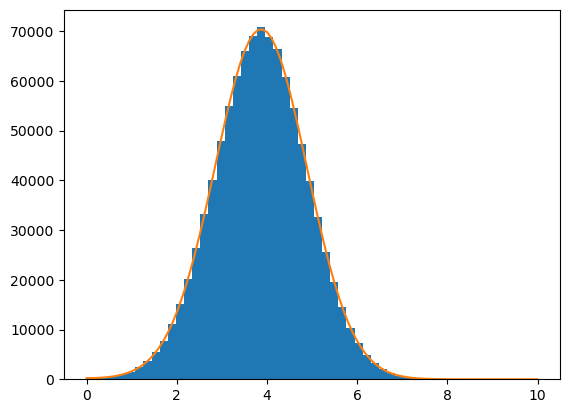

In [62]:
# Settings
o_SNR = 4
n = 10**6

# Test plot
e_SNR = np.linspace(0.001, 10, 101)
p_h1 = ncx2.pdf(e_SNR**2, 2, o_SNR**2)
norm = 1/np.trapz(p_h1, e_SNR)
start = time.time()
hist_samples = SNR_samples(o_SNR, n=n)
end = time.time()
print(f'Time: {end-start} seconds.')
fig=plt.hist(hist_samples, bins=50)
plt.plot(e_SNR, p_h1*n*norm*np.mean(np.diff(fig[1])))

The next stage is then to map the samples to eccentricity. We will handle the uncertainty introduced by the min/max lines simply by drawing uniformly between the eccentricity range of each sample.

Wrote a new function find_ecc_range_samples() which is capable of handling a list of matches as input. This function is significantly faster than passing the matches one at a time using a for loop.

In [5]:
def SNR2ecc(matches, chirp, interps, max_ecc=0.2):

    # Find upper and lower bounds on eccentricity for each sample
    ecc_arr = find_ecc_range_samples(matches, chirp, interps, max_ecc=max_ecc)

    # Put upper bound at max_ecc
    ecc_arr[ecc_arr>max_ecc] = max_ecc

    # Uniformly draw random value between these bounds for each sample
    eccs = np.random.rand(len(matches))*(ecc_arr[1]-ecc_arr[0]) + ecc_arr[0]

    return eccs

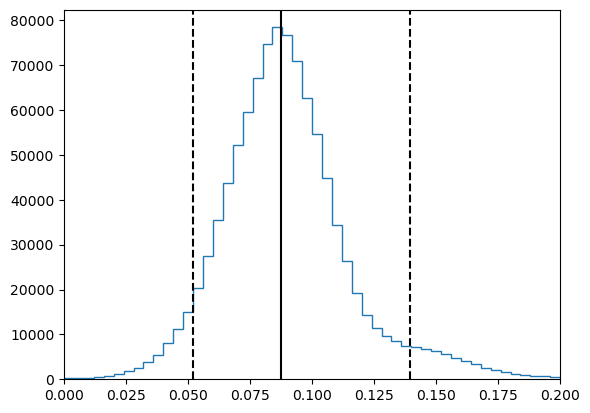

In [64]:
ecc_samples = SNR2ecc(hist_samples/40, 24, grid_data_20_30_5_interps[2])
fig=plt.hist(ecc_samples, bins=50, histtype='step')
plt.xlim(0,0.2)
quantiles = np.quantile(ecc_samples, [0.05, 0.5, 0.95])
plt.axvline(quantiles[0], c='k', ls='dashed')
plt.axvline(quantiles[1], c='k', ls='solid')
plt.axvline(quantiles[2], c='k', ls='dashed')

## More analytic approach

We could also try to a more analytic approach whereby we calculate the contribution of each match value to each eccentricity. This would then allow us to pass a function an array of eccentricities and receive the corresponding array of probabilities to plot.

In [46]:
def get_ecc_prob(eccs, chirp, obs_SNR, h0_SNR, interps, normalise=True, max_ecc=0.2, match_n=10**5):

    # Max/min line points corresponding to eccentricity
    max_line_arr = interps[0](chirp, eccs)
    min_line_arr = interps[1](chirp, eccs)

    # SNR probabilties
    match_arr = np.linspace(0, np.max(max_line_arr), match_n)
    match_prob = ncx2.pdf((match_arr*h0_SNR)**2, 2, obs_SNR**2)

    # Get width of min/max region for each match
    match_ecc_bounds = find_ecc_range_samples(match_arr, chirp, interps, max_ecc=max_ecc)
    match_ecc_width = np.diff(match_ecc_bounds, axis=0)[0]

    # Find indices of matches corresponding to each eccentricity
    max_match_args = np.array([np.argmin(np.abs(match_arr-x)) for x in max_line_arr])+1
    min_match_args = np.array([np.argmin(np.abs(match_arr-x)) for x in min_line_arr])

    # Calculate probability density for each eccentricity
    ecc_prob = np.array([np.sum(match_prob[x:y]/match_ecc_width[x:y]) for x,y in zip(min_match_args, max_match_args)])
    normalisation = np.trapz(ecc_prob, eccs)
    ecc_prob /= normalisation

    return ecc_prob

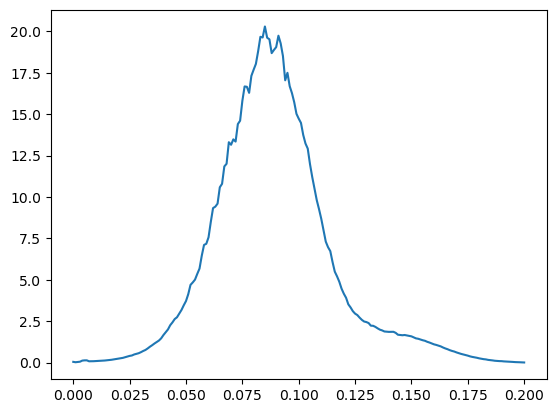

In [47]:
a = get_ecc_prob(np.linspace(0,0.2,201), 24, 4, 40, grid_data_20_30_5_interps[2])
plt.plot(np.linspace(0,0.2,201), a)

Find that line is not smooth, especially near peak. This is likely due to the min/max lines also not being smooth. Will therefore stick to sample method.

# Streamlined workflow

Collected here is all the code necessary to go from generating waveforms to calculating the 90% confidence interval on eccentricity.

This first block will in practice be pre-computed.

In [6]:
# Load grid data
with open(os.path.join('grid_data', 'dataslot_3', 'all_matches'), 'rb') as fp:
        grid_data_20_30_5 = pickle.load(fp)
grid_data_20_30_5 = find_min_max(grid_data_20_30_5)

# Compute interpolation objects
grid_data_20_30_5_interps = create_2D_interps(grid_data_20_30_5)

This second block sets the settings for the analysis, and generates the psd and frequency-domain strain data.

In [79]:
# Parameter settings
total_SNR = 40
chirp_mass = 24
ecc = 0.05
MA_shift = 0
ifos = ['H1']

In [80]:
# Calculate distance for specified SNR
s_d_test = gen_wf(10, ecc, chirp2total(chirp_mass, 2), 2, 4096, 'TEOBResumS', distance=1)
psd_d_test, _ = gen_psd(s_d_test, 10)
s_d_test_sigma = sigma(s_d_test.real(), psd_d_test, low_frequency_cutoff=10, high_frequency_cutoff=psd_d_test.sample_frequencies[-1])
distance = 1*np.sqrt(len(ifos))*s_d_test_sigma/total_SNR

# Calculate strain data (teobresums waveform) and psd
s_f_2pi = 10 - shifted_f(10, ecc, chirp2total(chirp_mass, 2), 2)
s_f = 10 - (MA_shift*s_f_2pi)
s_e = shifted_e(s_f, 10, ecc)
s_teob = gen_wf(s_f, s_e, chirp2total(chirp_mass, 2), 2, 4096, 'TEOBResumS', distance=distance)
chirp_mass_0p1 = favata_et_al_avg(ecc, chirp_mass, 0.1, 4096)[0]
fid_wf_len = gen_wf(10, 0.1, chirp2total(chirp_mass_0p1, 2), 2, 4096, 'TEOBResumS', distance=distance)
_, s_teob = resize_wfs([fid_wf_len, s_teob])
psd, _ = gen_psd(s_teob, 10)
s_teob_f = s_teob.real().to_frequencyseries()

# Creates objects used in SNR functions
data = {'H1': s_teob_f, 'L1': s_teob_f}
psds = {'H1': psd, 'L1': psd}
t_start = s_teob.sample_times[0]
t_end = s_teob.sample_times[-1]

This last block is the actual analysis we would have to perform for a real signal, followed by making plots.

In [81]:
# Generates fiducial waveforms in frequency domain
start = time.time()
_, h0, h1, h2, h3, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(chirp_mass_0p1, 2), 2, 4096)
h0_f, h1_f, h2_f, h3_f = [wf.real().to_frequencyseries() for wf in [h0, h1, h2, h3]]
h = {'h0': h0_f, 'h1': h1_f, 'h2': h2_f, 'h3': h3_f}

# Loop over detectors
z = {}
for ifo in ifos:

    # Normalise waveform modes
    h_perp = {}
    for key in h.keys():
        h_perp[key] = h[key] / sigma(h[key], psds[ifo], low_frequency_cutoff=10, high_frequency_cutoff=psds[ifo].sample_frequencies[-1])
    
    # Calculate mode SNRs
    mode_SNRs, _ = calculate_mode_snr(data[ifo], psds[ifo], h_perp, t_start, t_end, 10, h_perp.keys(), dominant_mode='h0')
    z[ifo] = mode_SNRs

# Calculate network SNRs
rss_snr, _ = network_mode_snr(z, ifos, z[ifos[0]].keys(), dominant_mode='h0')

# Draw SNR samples and convert to eccentricity samples
match_samples = SNR_samples(rss_snr['h1'], n=10**6)/rss_snr['h0']
ecc_samples = SNR2ecc(match_samples, 24, grid_data_20_30_5_interps[2])

# Compute 90% confidence bounds on h1/h0 SNR
rv = ncx2(2, rss_snr['h1']**2)
h1_CI_bounds = dist_min_CI(rv)
h1_h0_CI_bounds = h1_CI_bounds/rss_snr['h0']

# Compute 90% eccentric CI
ecc_CI_bounds = find_ecc_CI(h1_h0_CI_bounds, chirp_mass_0p1, grid_data_20_30_5_interps[2])

# Output result
end = time.time()
print(f'Eccentricity range of approximately {ecc_CI_bounds[0]:.3f} to {ecc_CI_bounds[1]:.3f} computed in {end-start:.3f} seconds.')

Eccentricity range of approximately 0.000 to 0.091 computed in 9.157 seconds.


## Plots

In [82]:
def SNR_fill_between(low, high, e_vals, chirp, max_line, interps, c, z):
    SNR_max_e = find_ecc_range(high, chirp, interps)[0]
    SNR_e_vals = e_vals[e_vals<=SNR_max_e]
    SNR_fill_lower = np.full_like(SNR_e_vals, low)
    SNR_fill_lower = np.max([SNR_fill_lower, max_line[e_vals<=SNR_max_e]], axis=0)
    SNR_fill_lower[SNR_fill_lower>high] = high
    plt.fill_between(SNR_e_vals, SNR_fill_lower, high, color=c, zorder=z)

def ecc_fill_between(low, high, chirp, interps, c, z):
    e_vals = np.arange(low, high+0.001, 0.001)
    e_fill_upper = interps[1](chirp, e_vals)
    plt.fill_between(e_vals, 0, e_fill_upper, color=c, zorder=z)

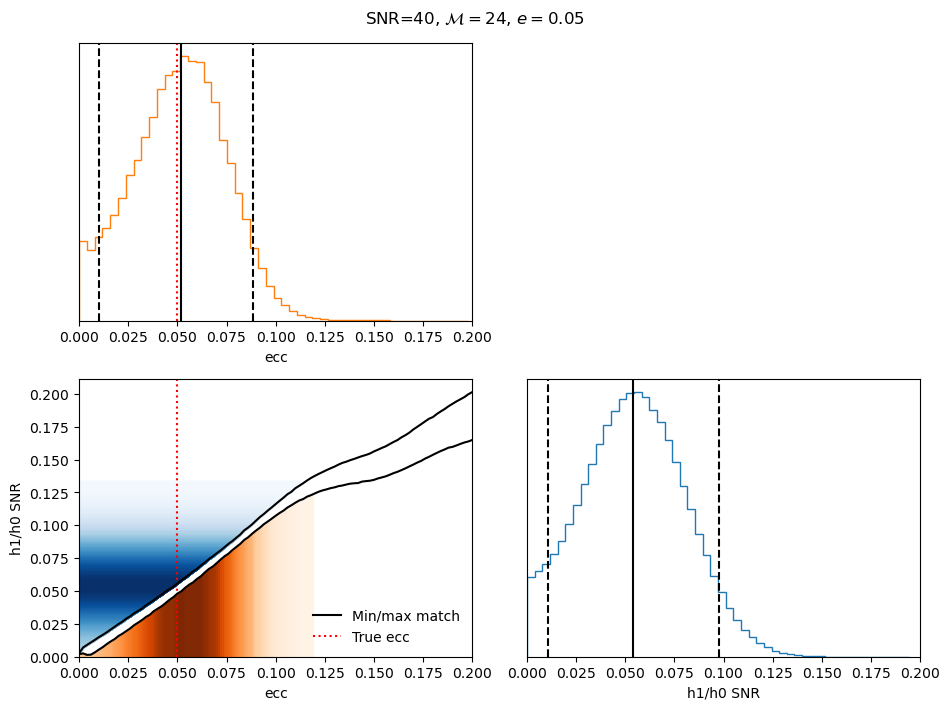

In [83]:
plt.figure(figsize=(6.4*1.5,4.8*1.5))

# Plot interpolated min/max match lines
plt.subplot(2,2,3)
first_chirp = list(data.keys())[0]
# e_vals = grid_data_20_30_5[first_chirp]['e_vals']
e_vals = np.linspace(0, 0.2, 101)
max_line = grid_data_20_30_5_interps[2][0](chirp_mass, e_vals)
min_line = grid_data_20_30_5_interps[2][1](chirp_mass, e_vals)
plt.plot(e_vals, max_line, c='k', zorder=3, label='Min/max match')
plt.plot(e_vals, min_line, c='k', zorder=3)
plt.axvline(ecc, c='r', ls='dotted', label='True ecc')
ylims = plt.gca().get_ylim()

# Plot SNR distribution
kde = gaussian_kde(match_samples)
match_vals = np.arange(0, np.max(match_samples)+0.001, 0.001)
kde_vals = kde(match_vals)
kde_max = np.max(kde_vals)
cmap = mpl.colormaps['Blues_r']
for i in range(99):
    idx = np.argwhere(np.diff(np.sign(kde_vals - kde_max*(99-i)/100))).flatten()
    if len(idx) == 0:
        continue
    if kde_vals[idx[0]] > kde_vals[idx[0]+1]:
        SNR_fill_between(0, match_vals[idx[0]], e_vals, chirp_mass, max_line, grid_data_20_30_5_interps[2], cmap(i/100), -i)
        idx = idx[1:]
        if len(idx) == 0:
            continue
    if kde_vals[idx[-1]+1] > kde_vals[idx[-1]]:
        SNR_fill_between(match_vals[idx[-1]], 1, e_vals, chirp_mass, max_line, grid_data_20_30_5_interps[2], cmap(i/100), -i)
        idx = idx[:-1]
        if len(idx) == 0:
            continue
    for j in range(0, len(idx), 2):
        SNR_fill_between(match_vals[idx[j]], match_vals[idx[j+1]], e_vals, chirp_mass, max_line, grid_data_20_30_5_interps[2], cmap(i/100), -i)

# Plot ecc distribution
kde = gaussian_kde(ecc_samples)
ecc_vals = np.arange(0, np.max(ecc_samples)+0.001, 0.001)
kde_vals = kde(ecc_vals)
kde_max = np.max(kde_vals)
cmap = mpl.colormaps['Oranges_r']
for i in range(99):
    idx = np.argwhere(np.diff(np.sign(kde_vals - kde_max*(99-i)/100))).flatten()
    if len(idx) == 0:
        continue
    if kde_vals[idx[0]] > kde_vals[idx[0]+1]:
        ecc_fill_between(0, ecc_vals[idx[0]], chirp_mass, grid_data_20_30_5_interps[2], cmap(i/100), -i)
        idx = idx[1:]
        if len(idx) == 0:
            continue
    if kde_vals[idx[-1]+1] > kde_vals[idx[-1]]:
        ecc_fill_between(ecc_vals[idx[-1]], 1, chirp_mass, grid_data_20_30_5_interps[2], cmap(i/100), -i)
        idx = idx[:-1]
        if len(idx) == 0:
            continue
    for j in range(0, len(idx), 2):
        ecc_fill_between(ecc_vals[idx[j]], ecc_vals[idx[j+1]], chirp_mass, grid_data_20_30_5_interps[2], cmap(i/100), -i)

# Plot formatting
plt.xlabel('ecc')
plt.ylabel('h1/h0 SNR')
plt.xlim(e_vals[0], e_vals[-1])
plt.ylim(0,ylims[1])
plt.legend(frameon=False)

# SNR histogram
plt.subplot(2,2,4)
fig=plt.hist(match_samples, bins=50, histtype='step', color='C0')
plt.xlim(0,0.2)
quantiles = np.quantile(match_samples, [0.05, 0.5, 0.95])
plt.axvline(quantiles[0], c='k', ls='dashed')
plt.axvline(quantiles[1], c='k', ls='solid')
plt.axvline(quantiles[2], c='k', ls='dashed')
plt.gca().yaxis.set_visible(False)
plt.xlabel('h1/h0 SNR')

# Ecc histogram
plt.subplot(2,2,1)
fig=plt.hist(ecc_samples, bins=50, histtype='step', color='C1')
plt.xlim(0,0.2)
quantiles = np.quantile(ecc_samples, [0.05, 0.5, 0.95])
plt.axvline(quantiles[0], c='k', ls='dashed')
plt.axvline(quantiles[1], c='k', ls='solid')
plt.axvline(quantiles[2], c='k', ls='dashed')
plt.axvline(ecc, c='r', ls='dotted')
plt.gca().yaxis.set_visible(False)
plt.xlabel('ecc')

# General formatting
plt.suptitle(f'SNR={total_SNR}' + ', $\mathcal{M}=$' + str(chirp_mass) + ', $e=$' + str(ecc))
plt.tight_layout()

# Save figure
plt.savefig('Figures/SNR2ecc.png')

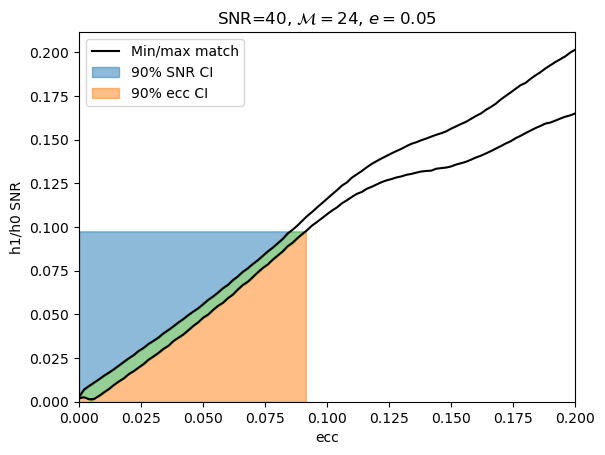

In [84]:
# Plot interpolated min/max match lines
first_chirp = list(data.keys())[0]
# e_vals = grid_data_20_30_5[first_chirp]['e_vals']
e_vals = np.linspace(0, 0.2, 101)
max_line = grid_data_20_30_5_interps[2][0](chirp_mass, e_vals)
min_line = grid_data_20_30_5_interps[2][1](chirp_mass, e_vals)
plt.plot(e_vals, max_line, c='k', zorder=3, label='Min/max match')
plt.plot(e_vals, min_line, c='k', zorder=3)

# Plot CIs
SNR_max_e = find_ecc_range(h1_h0_CI_bounds[1], chirp_mass, grid_data_20_30_5_interps[2])[0]
SNR_e_vals = e_vals[e_vals<=SNR_max_e]
SNR_fill_lower = np.full_like(SNR_e_vals, h1_h0_CI_bounds[0])
SNR_fill_lower = np.max([SNR_fill_lower, max_line[e_vals<=SNR_max_e]], axis=0)
SNR_fill_lower[SNR_fill_lower>h1_h0_CI_bounds[1]] = h1_h0_CI_bounds[1]
plt.fill_between(SNR_e_vals, SNR_fill_lower, h1_h0_CI_bounds[1], color='C0', alpha=0.5, label='90% SNR CI')
CI_e_vals = np.linspace(ecc_CI_bounds[0], ecc_CI_bounds[1], 1001)
e_fill_upper = grid_data_20_30_5_interps[2][1](chirp_mass, CI_e_vals)
e_fill_upper[e_fill_upper<h1_h0_CI_bounds[0]] = h1_h0_CI_bounds[0]
plt.fill_between(CI_e_vals, 0, e_fill_upper, color='C1', alpha=0.5, label='90% ecc CI')
comb_fill_upper = grid_data_20_30_5_interps[2][0](chirp_mass, CI_e_vals)
comb_fill_upper[comb_fill_upper>h1_h0_CI_bounds[1]] = h1_h0_CI_bounds[1]
plt.fill_between(CI_e_vals, e_fill_upper, comb_fill_upper, color='C2', alpha=0.5)

# Plot formatting
plt.xlabel('ecc')
plt.ylabel('h1/h0 SNR')
plt.title(f'SNR={total_SNR}' + ', $\mathcal{M}=$' + str(chirp_mass) + ', $e=$' + str(ecc))
plt.xlim(e_vals[0], e_vals[-1])
plt.ylim(0,)
plt.legend()